# Семинар 3. Определение максимально правдоподобных распределений для данных

Для того, чтобы корректно применять статистические тесты, а также выуживать из данных максимальное количество информации, которая в них хранится, необходимо точно понимать, по какому закону эти данные распределены.

На этом семинаре мы разберём, как корректно понять, что именно за распределение в данных мы наблюдаем. Для примера мы загрузим набор данных из ресурса <a href="https://jhubiostatistics.shinyapps.io">ReCount2</a> (в целом это полезный ресурс в случае, если вам необходимо загрузить из открытых источников именно RNA-Seq count data).

In [ ]:
# Загрузка R magic
%load_ext rpy2.ipython

# Установка нужных пакетов
!Rscript -e 'install.packages("fitdistrplus", repos="https://cloud.r-project.org")'

# Загрузка датасета
!gdown --id 1nlpCcK6LoqEJnvCqEdcUFNElZSoz_3Kg

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/fitdistrplus_1.1-8.tar.gz'
Content type 'application/x-gzip' length 2434918 bytes (2.3 MB)
downloaded 2.3 MB

* installing *source* package ‘fitdistrplus’ ...
** package ‘fitdistrplus’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (fitdistrplus)

The downloaded source packages are in
	‘/tmp/Rtmp5zFcXm/downloaded_packages’
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be rem

In [ ]:
!gdown --id 1nlpCcK6LoqEJnvCqEdcUFNElZSoz_3Kg

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1nlpCcK6LoqEJnvCqEdcUFNElZSoz_3Kg
To: /content/LUAD_counts.tsv
100% 3.18M/3.18M [00:00<00:00, 162MB/s]


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Настройка отображения
plt.rcParams["figure.dpi"] = 100

In [ ]:
# Прочтение датасета
df = pd.read_csv("LUAD_counts.tsv", sep="\t")
df.index = [gene.split(".")[0] for gene in df.gene_name]
del df["gene_name"]
df = df.T

In [ ]:
df.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,ACTL10,AC119733,AC020765,AC010980,AC004233,AL451106,AC008763,AC006486,AL391628,AP006621
sample_0,4275,0,1071,630,542,372,10445,6760,31744,2022,...,0,0,0,11,0,0,0,0,6,10
sample_1,1536,0,765,510,172,911,4290,1097,807,1043,...,0,0,0,15,1,0,1,0,6,9
sample_2,5009,13,2731,919,321,2299,9368,3812,2704,2496,...,0,0,0,36,2,0,0,0,15,18
sample_3,1889,0,1941,548,301,879,5994,2310,2552,1332,...,0,0,1,17,0,0,0,0,3,22
sample_4,1329,0,1395,297,320,387,6215,3142,685,1676,...,0,0,0,9,3,0,0,0,2,9


Первое, что необходимо сделать, &mdash; это посмотреть на распределение данных глазами, построив гистограмму.

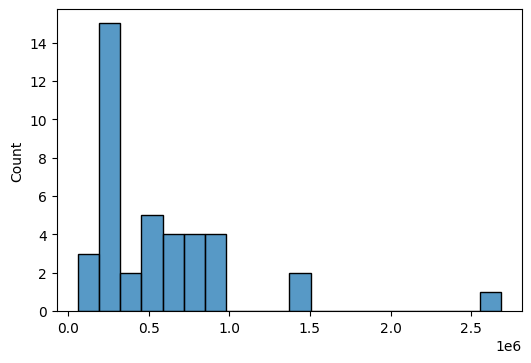

In [ ]:
gene = "MT-CO1"
expr = np.array(df[gene])
sns.histplot(expr, bins=20)

В принципе похоже на нормальное распределение, не так ли? Легко можно представить, как именно на таких данных запускают классический t-test. Однако давайте оценим его нормальность при помощи классического теста, который проходят в университете.

In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(df[gene])
print(f"Statistics={stat:3f}, p={p:3f}")

Statistics=0.742976, p=0.000001


Уже не выглядит так, что данные нормальные, да? Как вообще понимают, какое распределение описывает данные лучше всего? Для начала разберёмся, как оценивают, хорошо ли описываются данные каким-то распределением. При помощи пакета <code>fitdistrplus</code> для R попробуем описать наши данные нормальным распределением и разберём, что конкретно происходило.

## Зависимость дисперсии от среднего

In [ ]:
means = np.mean(df.values, axis=0)
vars = np.var(df.values, axis=0)

means = means[vars > 0]
vars = vars[vars > 0]

means = np.log10(means)
vars = np.log10(vars)

Text(0, 0.5, 'log$_{10}$(Variance)')

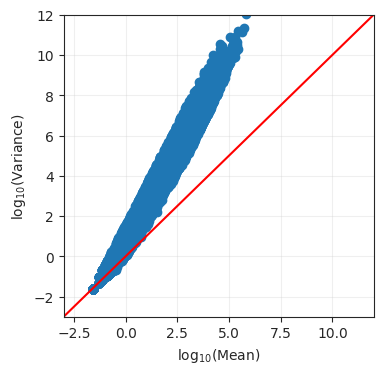

In [ ]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)

ax.scatter(means, vars)
ax.plot([-3, 12], [-3, 12], color="red")
ax.set_xlim(-3, 12)
ax.set_ylim(-3, 12)
ax.grid(alpha=0.3)

ax.set_xlabel("log$_{10}$(Mean)")
ax.set_ylabel("log$_{10}$(Variance)")

## Тестирование конкретного распределения

Допустим, мы знаем, что наш набор данных описывается нормальным распределением (или каким-либо иным параметрическим распределением). Но как определить, какие именно параметры такого распределения? Мы можем найти максимально правдоподобную оценку такого распределения.

In [ ]:
%%R -i expr
library(fitdistrplus)

In [ ]:
%%R
data <- as.vector(expr)
fit.norm <- fitdist(data, "norm")
summary(fit.norm)

Fitting of the distribution ' norm ' by maximum likelihood 
Parameters : 
     estimate Std. Error
mean 553010.3          0
sd   464404.5          0
Loglikelihood:  -578.698   AIC:  1161.396   BIC:  1164.774 
Correlation matrix:
     mean  sd
mean    1 NaN
sd    NaN   1



Нарисуем графики для анализа:

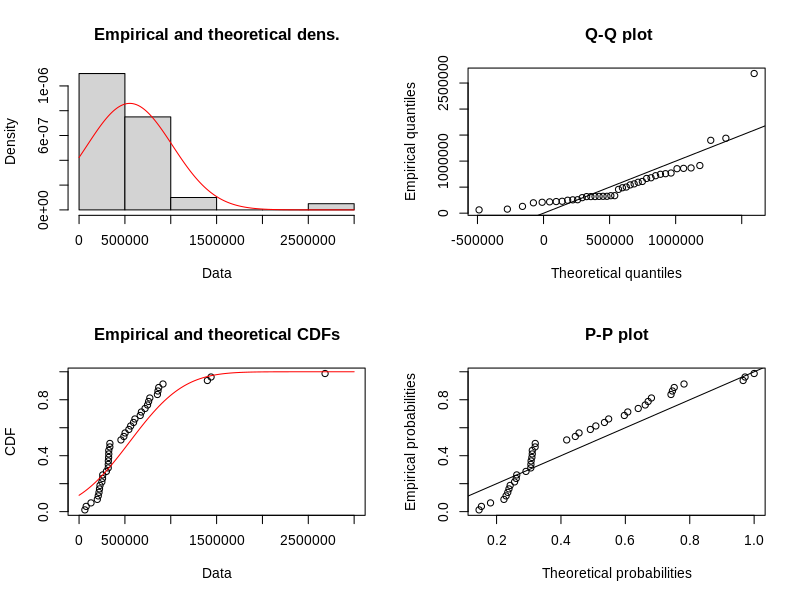

In [ ]:
%%R -r 100 -w 800 -h 600
plot(fit.norm)

Пока будем ориентироваться только на правдоподобие того, что данные порождены этим распределением. Как вы думаете, у нас высокое или низкое значение правдоподобия?

### Задание

Сравните несколько распределений и определите, какое из них, по вашему мнению, лучше всего описывает данные. Для того, чтобы найти доступные для использования распределения, прочитайте документацию пакета по <a href="https://cran.r-project.org/web/packages/fitdistrplus/fitdistrplus.pdf">ссылке</a>.

## Сравнение тестов между собой

После того, как мы нашли Likelihood того, что наши данные порождены определённым распределением с определёнными параметрами, нам необходимо сравнить модели между собой, чтобы понять, какая из них описывает данные лучше. Казалось бы, можно сравнить правдоподобия и всё, однако у распределений есть ещё один важный параметр, который мы не учли, &mdash; это число параметров самой модели.

Для того, чтобы учитывать число параметров самой модели, существует информационный критерий Акаике
$\mathrm{AIC} = 2k – 2(\mathrm{LogLikelihood})$, где $k$ &mdash; это число параметров модели. И то распределение, которое будет иметь меньшее значение AIC, и будет более предпочтительным.

Посмотрим заново на результаты того, как мы зафитили нашу модель:

In [ ]:
%%R
summary(fit.norm)

Fitting of the distribution ' norm ' by maximum likelihood 
Parameters : 
     estimate Std. Error
mean 553010.3          0
sd   464404.5          0
Loglikelihood:  -578.698   AIC:  1161.396   BIC:  1164.774 
Correlation matrix:
     mean  sd
mean    1 NaN
sd    NaN   1



Так же мы можем сравнить CDF нашего распределения и тех распределений, которые мы зафитили:

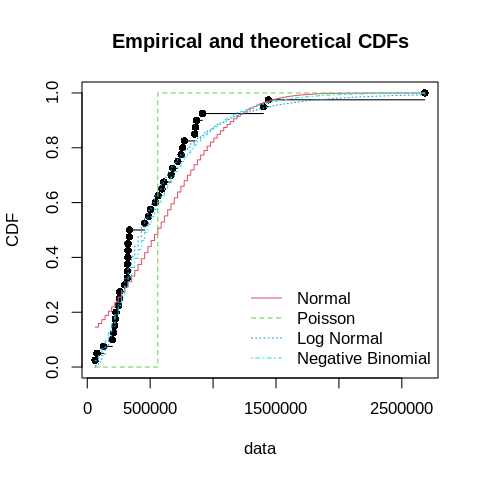

In [ ]:
%%R -r 100
fit_n  <- fitdist(data, "norm")
fit_p  <- fitdist(data, "pois")
fit_nb  <- fitdist(data, "nbinom")
fit_ln  <- fitdist(data, "lnorm")
cdfcomp(list(fit_n, fit_p, fit_ln, fit_nb), legendtext = c("Normal", "Poisson", "Log Normal", "Negative Binomial"))

NameError: ignored

In [ ]:
%%R
summary(fit_nb)

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate Std. Error
size 1.990279e+00         NA
mu   5.528951e+05         NA
Loglikelihood:  -564.3479   AIC:  1132.696   BIC:  1136.074 
Correlation matrix:
[1] NA



In [ ]:
%%R
summary(fit_n)

Fitting of the distribution ' norm ' by maximum likelihood 
Parameters : 
     estimate Std. Error
mean 553010.3          0
sd   464404.5          0
Loglikelihood:  -578.698   AIC:  1161.396   BIC:  1164.774 
Correlation matrix:
     mean  sd
mean    1 NaN
sd    NaN   1



Также для того, чтобы оценить нестабильность наших данных, можно использовать бутстрэп.

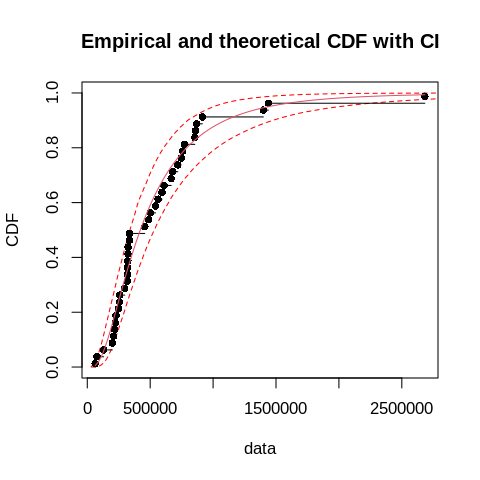

In [ ]:
%%R -r 100
fit_ln.boot <- bootdist(fit_ln, "param")
CIcdfplot(fit_ln.boot, CI.output = "probability")

Или использовать оценки третьего и четвёртого моментов для того, чтобы хотя бы приблизительно понять, к какому распределению наши данные могут быть отнесены:

summary statistics
------
min:  62918   max:  2682832 
median:  396275.5 
mean:  553010.3 
estimated sd:  470320.8 
estimated skewness:  2.709948 
estimated kurtosis:  13.21073 


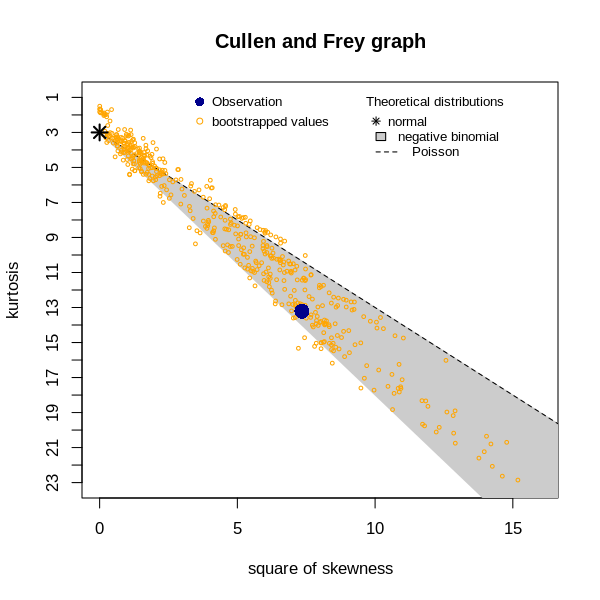

In [ ]:
%%R -r 100 -w 600 -h 600
descdist(data, discrete=TRUE, boot=500)

## Домашнее задание

Определите максимально правдоподобное распределение для наших даных. Попробуйте это сделать на случайной выборке из экспрессий 30 других генов. Согласованный ли получился результат?

In [ ]:
from random import sample
import itertools

In [ ]:
list(df.columns)
genes=sample(list(df.columns),30)
data=df[genes]
data.shape

(40, 30)

In [ ]:
(data==0).sum()

ZNF92        0
STIM2        0
POLR2B       0
TBL1X        0
ADGRE1       0
DLG1         0
MMP16        0
CACNA2D1     0
HTRA3        0
AL159163    22
CREB3L2      0
CCDC138      0
C1orf112     0
MSANTD1      0
ARID4A       0
NMNAT3       0
ZNF507       0
LGALS3BP     0
NDRG4        0
OR9I1       40
TERF2        0
ZMIZ1        0
KLHL30       0
NCR3LG1      0
SCGB1C2     34
TTLL4        0
TAX1BP3      0
CLEC4G      39
MDM1         0
MATN4        2
dtype: int64

In [ ]:
%%R 
library(fitdistrplus)
aic<-function(data, distr){
    data<-as.vector(data)
    fit_distr <- fitdist(data, distr)
    aic_val<-fit_distr[['aic']]
    return(aic_val)
}

In [ ]:
from pandas.io.formats.format import NA
distrs=['norm','pois','nbinom','lnorm']
aics = pd.DataFrame(columns=distrs, index=genes)
for gene, distr in itertools.product(genes, distrs):
  gene_data=data[gene].values
  try:
    %R -i gene_data,distr -o aic_val aic_val=aic(gene_data,distr)
    aics.loc[gene][distr]=aic_val[0]
  except Exception:
    pass

In [ ]:
aics

,norm,pois,nbinom,lnorm
ZNF92,562.894059,5273.221283,556.696095,557.00361
STIM2,735.702834,58620.121936,700.53577,691.080405
POLR2B,758.923214,64909.767906,744.851833,743.762879
TBL1X,723.477601,50953.041402,700.522207,697.764901
ADGRE1,599.536947,17848.113269,491.608539,473.737051
DLG1,697.767683,26361.651611,691.150617,691.170988
MMP16,493.608177,3819.260423,463.142406,461.492916
CACNA2D1,683.589386,38364.156594,611.606419,597.83809
HTRA3,772.034512,114257.837139,740.805762,741.197848
AL159163,120.870342,100.290906,99.317763,NaN


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 53.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


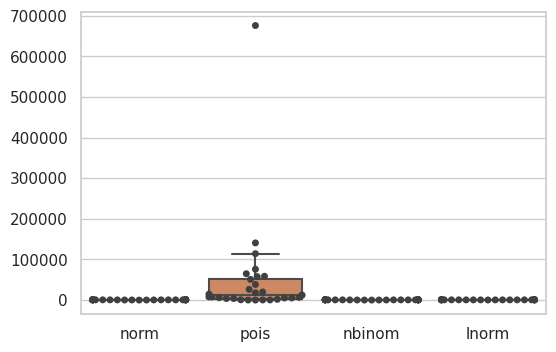

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")


ax = sns.boxplot(data=aics, showfliers = False)
ax = sns.swarmplot(data=aics, color=".25")

plt.show()

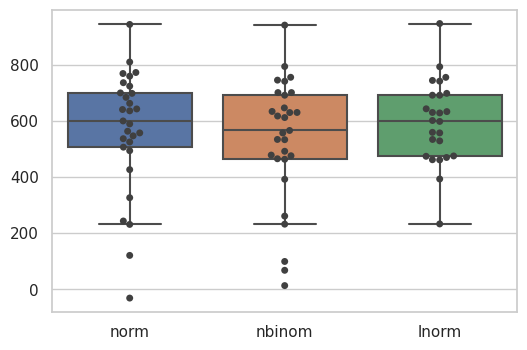

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")


ax = sns.boxplot(data=aics[['norm','nbinom','lnorm']], showfliers = False)
ax = sns.swarmplot(data=aics[['norm','nbinom','lnorm']], color=".25")

plt.show()

Самый низкая медиана AIC у отрицательного биномиального распределения. Я попробовала  

###Задание 2.
Скачайте датасет <code>1M8-86VecaYPERovPk4JKhT2lLa4PfJxi</code> из статьи <a href="https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-13-304#Sec8">Oberg et al., 2012</a>. Внимательно прочитайте статью и изучите дизайн эксперимента &mdash; какие реплики в статье называют техническими, а какие &mdash; биологическими? Правда ли в технических репликах наблюдается распределение Пуассона?

Чтобы получить технические реплики в статье одну и ту же библиотеку капали в разные дорожки секвенатора. Полученные из этих дорожек данные как раз и называют техническим репликами.

Биологические реплики - образцы из разных индивидумов, которые относятся к одной и той же группе (high или low responders)

In [ ]:
!gdown --id 1M8-86VecaYPERovPk4JKhT2lLa4PfJxi

In [6]:
# Прочтение датасета
df = pd.read_csv("GSE29022_gene_counts.txt", sep="\t")
df.shape

(17353, 48)

In [7]:
df.head()

,sample4019.flowcell30WPLAAXX.lane5,sample4019.flowcell30WPLAAXX.lane6,sample6045.flowcell30WP5AAXX.lane1,sample6045.flowcell30WP5AAXX.lane2,sample2550.flowcell305TMAAXX.lane3,sample2550.flowcell305TMAAXX.lane4,sample1286.flowcell305TMAAXX.lane7,sample1286.flowcell305TMAAXX.lane8,sample6113.flowcell30WFYAAXX.lane3,sample6113.flowcell30WFYAAXX.lane4,...,sample1353.flowcell42KV5AAXX.lane7,sample1353.flowcell42KV5AAXX.lane8,sample56.flowcell42KT7AAXX.lane3,sample56.flowcell42KT7AAXX.lane4,sample7954.flowcell42KT7AAXX.lane7,sample7954.flowcell42KT7AAXX.lane8,sample6310.flowcell312M0AAXX.lane3,sample6310.flowcell312M0AAXX.lane4,sample86.flowcell312M0AAXX.lane7,sample86.flowcell312M0AAXX.lane8
0,785,761,794,888,873,836,930,874,1053,1050,...,2173,2043,2301,2552,1252,1115,2516,2495,1835,1761
1,527,501,466,581,259,259,321,361,381,391,...,786,720,759,780,1122,1084,803,731,785,679
2,3,2,3,1,1,1,2,2,2,3,...,1,5,4,3,1,2,0,2,4,4
3,117,129,80,71,61,52,74,70,55,74,...,202,176,141,133,194,198,157,161,192,189
4,30,30,19,34,16,21,15,24,16,21,...,33,32,19,22,43,37,28,26,52,44


Получается, что для каждого образца у нас только по две технические реплики. Оценивать только по двум точкам среднее и дисперсию ооочень странно, поэтому рисовать график дисперсии против среднего не буду (он не информативный)

In [52]:
means=np.empty([1,24*df.shape[0]])
vars=np.empty([1,24*df.shape[0]])
for i in range(df.shape[1]//2):
  means[0,i*df.shape[0]:(i+1)*df.shape[0]]=np.mean(df.iloc[:, i:i+4], axis=1).values
  vars[0,i*df.shape[0]:(i+1)*df.shape[0]]=np.var(df.iloc[:,  i:i+4], axis=1).values

In [53]:
means = means[vars > 0]
vars = vars[vars > 0]
means = np.log10(means)
vars = np.log10(vars)

Text(0, 0.5, 'log$_{10}$(Variance)')

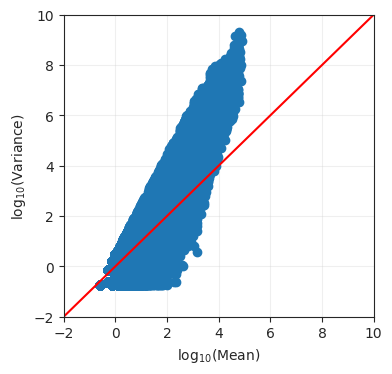

In [56]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)

ax.scatter(means, vars)
ax.plot([-2, 10], [-2, 10], color="red")
ax.set_xlim(-2, 10)
ax.set_ylim(-2, 10)
ax.grid(alpha=0.3)

ax.set_xlabel("log$_{10}$(Mean)")
ax.set_ylabel("log$_{10}$(Variance)")

###Задание 3.
Проделайте подобную процедуру с каунтами генов, которые вы получили в результате анализа <a href="https://www.nature.com/articles/s41598-018-23226-4">статьи</a> со сравнением методов подготовки библиотек для scRNA-Seq (`1Mh2T7YyWG9LPQsuNGy_IdYhbbzUgZUek`). Разберитесь, что в случае этой работы называют технической репликой. Актуально ли распределение Пуассона в случае таких технических реплик?

В этой статье для получения технических реплик из каждой аликвоты образца делали отдельную библиотеку. 

In [8]:
!gdown --id 1Mh2T7YyWG9LPQsuNGy_IdYhbbzUgZUek

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Mh2T7YyWG9LPQsuNGy_IdYhbbzUgZUek
To: /content/polyA_total_counts.tsv
100% 1.87M/1.87M [00:00<00:00, 131MB/s]


In [12]:
# Прочтение датасета
df2 = pd.read_csv("polyA_total_counts.tsv", sep="\t")
df2.index = df2['Unnamed: 0']
del df2['Unnamed: 0']
df2.head()

,colon_polyA_3,colon_polyA_4,colon_polyA_1,colon_polyA_2,colon_total_3,colon_total_4,colon_total_1,colon_total_2,pbmc_polyA_3,pbmc_polyA_4,pbmc_polyA_1,pbmc_polyA_2,pbmc_total_3,pbmc_total_4,pbmc_total_1,pbmc_total_2
Unnamed: 0,,,,,,,,,,,,,,,,
MAFIP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
KIR3DL2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
KIR3DL2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
KIR3DL2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
KIR3DL2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
#col_name="_".join(df2.columns[i].split('_')[0:2])

'colon_polyA'

In [35]:
df2.shape

(21533, 16)

In [ ]:
means=np.empty([1,4*df2.shape[0]])
vars=np.empty([1,4*df2.shape[0]])
for i in range(df2.shape[1]//4):
  means[0,i*df2.shape[0]:(i+1)*df2.shape[0]]=np.mean(df2.iloc[:, i:i+4], axis=1).values
  vars[0,i*df2.shape[0]:(i+1)*df2.shape[0]]=np.var(df2.iloc[:,  i:i+4], axis=1).values

In [ ]:
means = means[vars > 0]
vars = vars[vars > 0]
means = np.log10(means)
vars = np.log10(vars)

Text(0, 0.5, 'log$_{10}$(Variance)')

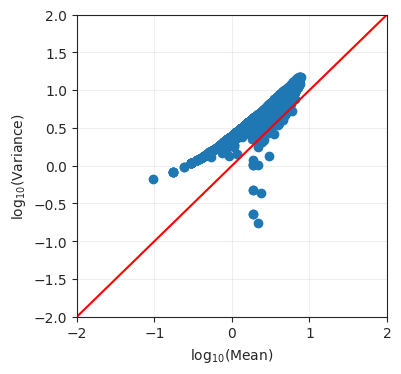

In [50]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)

ax.scatter(means, vars)
ax.plot([-2, 2], [-2, 2], color="red")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.grid(alpha=0.3)

ax.set_xlabel("log$_{10}$(Mean)")
ax.set_ylabel("log$_{10}$(Variance)")